<center>
<img src="../../../mlcourse.ai/img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

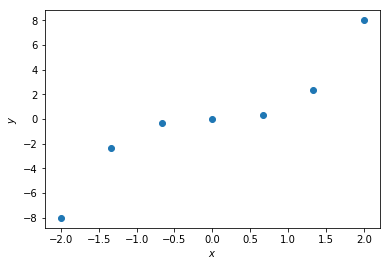

In [31]:


plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [32]:
# Ваш код здесь ??? 
X.mean()

-6.344131569286608e-17

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [33]:
# Ваш код здесь
np.mean([x for x in X if x<0])

-1.3333333333333333

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [34]:
def regression_var_criterion(X, t):
    X_left = np.array([x for x in X if x < t])
    X_right = np.array([x for x in X if x >= t])
    return X.var() - len(X_left)/len(X)*X_left.var() - len(X_right)/len(X)*X_right.var()

In [29]:
d = {}
for t in range(-19, 20, 1):
    d[t] = regression_var_criterion(X, t/10)
sorted(d.items(), key=lambda x: x[1], reverse=True)[0]

(-6, 1.3333333333333335)

In [337]:
sorted(d.items(), key=lambda x: x[1], reverse=True)

[(-6, 1.3333333333333335),
 (-5, 1.3333333333333335),
 (-4, 1.3333333333333335),
 (-3, 1.3333333333333335),
 (-2, 1.3333333333333335),
 (-1, 1.3333333333333335),
 (0, 1.3333333333333335),
 (1, 1.3333333333333335),
 (2, 1.3333333333333335),
 (3, 1.3333333333333335),
 (4, 1.3333333333333335),
 (5, 1.3333333333333335),
 (6, 1.3333333333333335),
 (-13, 1.1111111111111112),
 (-12, 1.1111111111111112),
 (-11, 1.1111111111111112),
 (-10, 1.1111111111111112),
 (-9, 1.1111111111111112),
 (-8, 1.1111111111111112),
 (-7, 1.1111111111111112),
 (7, 1.111111111111111),
 (8, 1.111111111111111),
 (9, 1.111111111111111),
 (10, 1.111111111111111),
 (11, 1.111111111111111),
 (12, 1.111111111111111),
 (13, 1.111111111111111),
 (14, 0.666666666666667),
 (15, 0.666666666666667),
 (16, 0.666666666666667),
 (17, 0.666666666666667),
 (18, 0.666666666666667),
 (19, 0.666666666666667),
 (-19, 0.6666666666666667),
 (-18, 0.6666666666666667),
 (-17, 0.6666666666666667),
 (-16, 0.6666666666666667),
 (-15, 0.6666666

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет ###

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [37]:
X_left = np.array([x for x in X if x < 0])
X_right = np.array([x for x in X if x > 0])

X_left_left = [x for x in X_left if x < -1.5]
X_left_right = [x for x in X_left if x >= -1.5]

X_right_left = [x for x in X_right if x < 1.5]
X_right_right = [x for x in X_right if x > 1.5]
X_left_left, X_left_right, X_right_left, X_right_right

([-2.0],
 [-1.3333333333333335, -0.6666666666666667],
 [0.6666666666666665, 1.333333333333333],
 [2.0])

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6 ###
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [63]:
df = pd.read_csv('../../../mlcourse.ai/data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [64]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [65]:
df["age_in_years"] = df.apply(lambda x: int(x['age']/365), axis=1)

df = pd.concat([df, pd.get_dummies(df['cholesterol'], prefix="chol"),
               pd.get_dummies(df['gluc'], prefix="gluc")], axis=1)

y = df['cardio'] # Целевая функция
df.drop(['cholesterol', 'gluc', 'cardio', 'age'], axis=1, inplace=True)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, random_state=17, test_size=0.3)

In [69]:
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_in_years,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0


Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/)

In [80]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train);

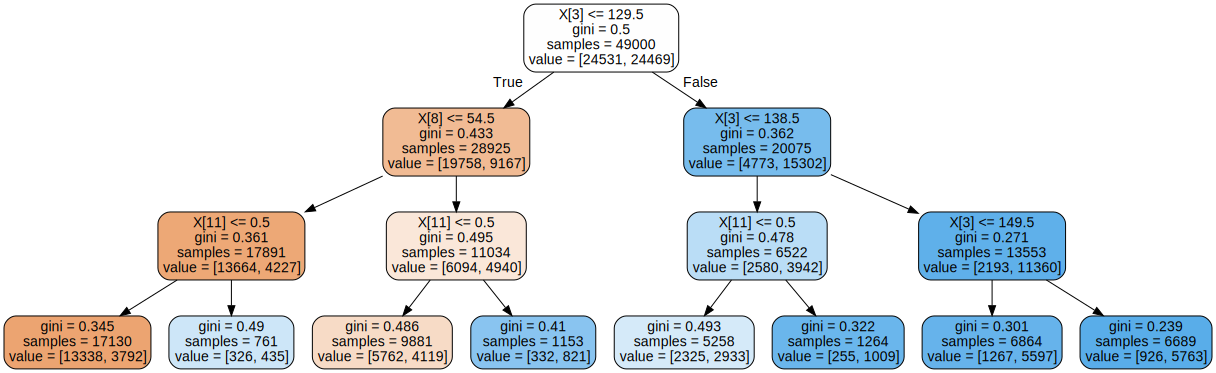

In [81]:
dot_data = export_graphviz(tree, out_file=None, filled=True, rounded=True)
graphviz.Source(dot_data)

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3 ###

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [82]:
accuracy_score(y_valid, tree.predict(X_valid))

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [83]:
tree_params = {'max_depth': list(range(2, 11))}
test_tree = DecisionTreeClassifier(random_state=17)
tree_grid = GridSearchCV(test_tree, tree_params, cv=5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

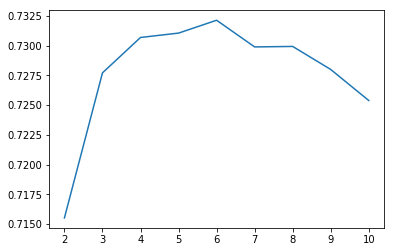

In [98]:
plt.plot([x for x in range(2, 11)], tree_grid.cv_results_['mean_test_score']);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [107]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 6}, 0.7321428571428571)

In [113]:
acc1 = accuracy_score(y_valid, tree.predict(X_valid))
acc2 = tree_grid.best_score_
(acc2 - acc1) / acc1 * 100

1.5052485640720839

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да ###
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../../mlcourse.ai/img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.) ###
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [317]:
df = pd.read_csv('../../../mlcourse.ai/data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

df['Age'] = df.apply(lambda x: int(x['age']/365), axis=1)
df.drop('age', axis=1, inplace=True)
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Age
id,,,,,,,,,,,,
0,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,156,85.0,140,90,3,1,0,0,1,1,55
2,1,165,64.0,130,70,3,1,0,0,0,1,51
3,2,169,82.0,150,100,1,1,0,0,1,1,48
4,1,156,56.0,100,60,1,1,0,0,0,0,47


In [318]:
df['45-50'] = df.apply(lambda row: 1 if 45 <= row['Age'] and row['Age'] < 50 else 0, axis=1)
df['50-55'] = df.apply(lambda row: 1 if 50 <= row['Age'] and row['Age'] < 55 else 0, axis=1)
df['55-60'] = df.apply(lambda row: 1 if 55 <= row['Age'] and row['Age'] < 60 else 0, axis=1)
df['60-65'] = df.apply(lambda row: 1 if 60 <= row['Age'] and row['Age'] < 65 else 0, axis=1)

In [319]:
df['ap_hi_120-140'] = df.apply(lambda row: 1 if 120 <= row['ap_hi'] and row['ap_hi'] < 140 else 0, axis=1)
df['ap_hi_140-160'] = df.apply(lambda row: 1 if 140 <= row['ap_hi'] and row['ap_hi'] < 160 else 0, axis=1)
df['ap_hi_160-180'] = df.apply(lambda row: 1 if 160 <= row['ap_hi'] and row['ap_hi'] < 180 else 0, axis=1)

In [320]:
df.sample(5)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Age,45-50,50-55,55-60,60-65,ap_hi_120-140,ap_hi_140-160,ap_hi_160-180
id,,,,,,,,,,,,,,,,,,,
54720,1,159,53.0,110,70,1,1,0,0,1,0,58,0,0,1,0,0,0,0
92761,2,170,75.0,120,80,1,1,0,0,1,0,42,0,0,0,0,1,0,0
92660,1,158,62.0,110,80,1,1,0,0,1,0,52,0,1,0,0,0,0,0
94834,1,160,60.0,110,70,1,1,0,1,0,0,53,0,1,0,0,0,0,0
14692,1,159,62.0,120,80,1,1,0,0,1,0,50,0,1,0,0,1,0,0


In [321]:
df = pd.concat([df, pd.get_dummies(df['cholesterol'], prefix='chol')], axis=1)
df['male'] = df['gender'].map({1: 0, 2: 1})

In [322]:
df.columns

Index(['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
       'smoke', 'alco', 'active', 'cardio', 'Age', '45-50', '50-55', '55-60',
       '60-65', 'ap_hi_120-140', 'ap_hi_140-160', 'ap_hi_160-180', 'chol_1',
       'chol_2', 'chol_3', 'male'],
      dtype='object')

In [323]:
y = df.cardio

In [325]:
df.drop(['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
         'alco', 'active', 'cardio', 'Age'], axis=1, inplace=True)

In [333]:
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, random_state=17, test_size=1)

In [334]:
dt = DecisionTreeClassifier(max_depth=3, random_state=17)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

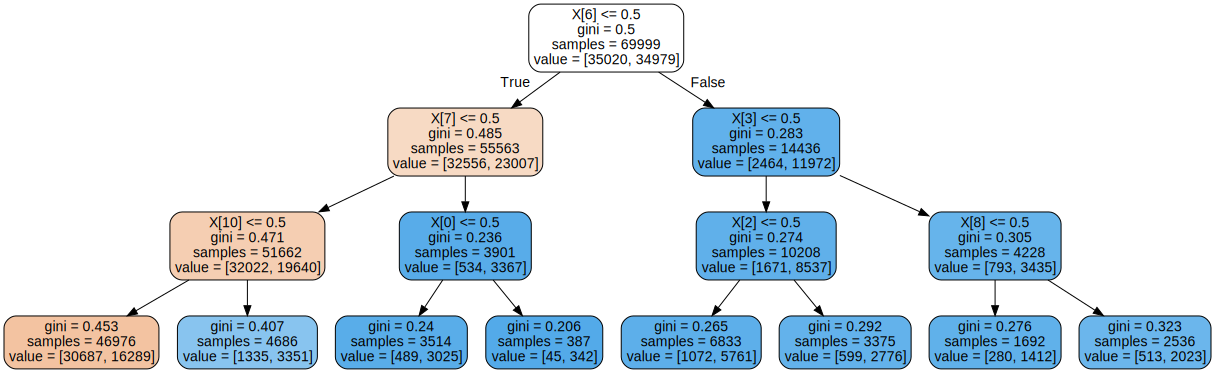

In [335]:
graphviz.Source(export_graphviz(dt, out_file=None, filled=True, rounded=True))

In [329]:
df.sample(5)

,smoke,45-50,50-55,55-60,60-65,ap_hi_120-140,ap_hi_140-160,ap_hi_160-180,chol_1,chol_2,chol_3,male
id,,,,,,,,,,,,
24770,0,0,0,0,0,0,0,0,1,0,0,0
98109,0,0,0,0,0,0,0,0,1,0,0,1
20505,0,0,0,1,0,0,1,0,1,0,0,1
94337,0,0,0,1,0,0,0,1,1,0,0,0
52083,0,0,0,1,0,1,0,0,1,0,0,0
